# Binary Classification using Pima Indians Diabetes Database

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
attributes = [
    "Pregnancies", # Number of times pregnant
    "PlasmaGlucose", # Plasma Glucose Concentration in 2hr oral glucose tolerance test
    "DiastolicBloodPressure", # Diastolic blood pressure (mm Hg)
    "TricepSkinFoldThickness", # Triceps skin fold thickness (mm)
    "SerumInsulin", # 2-Hour serum insulin (mu U/ml)
    "BMI", # Body mass index (weight in kg/(height in m)^2)
    "DiabetesPedigree", # Diabetes pedigree function
    "Age", # Age (years)
    "Target" # Negative or Positive for diabetes (0 or 1)
]

fileName = "data/pima-indians-diabetes/pima-indians-diabetes.data"
df = pd.read_csv(fileName, names=attributes)

## Data Exploration

Let's have a peak!

In [3]:
df.head()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepSkinFoldThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                768 non-null int64
PlasmaGlucose              768 non-null int64
DiastolicBloodPressure     768 non-null int64
TricepSkinFoldThickness    768 non-null int64
SerumInsulin               768 non-null int64
BMI                        768 non-null float64
DiabetesPedigree           768 non-null float64
Age                        768 non-null int64
Target                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


Since this dataset has come from the UCI Machine Learning Repository, you can see that it is quite clean (no missing values etc.)

In [5]:
df.describe()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepSkinFoldThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Target
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


No text! Just discrete and continous values.

In [6]:
classCounts = pd.value_counts(df.Target.values, sort=False)

'{} patients that tested positive and {} that tested negative.'.format(classCounts[0], classCounts[1])

'500 patients that tested positive and 268 that tested negative.'

Our labels are quite unbalanced (i.e. nearly 2 to 1). Luckily, there are more negatively tested labels than positive...

### Time to play with some graphs!

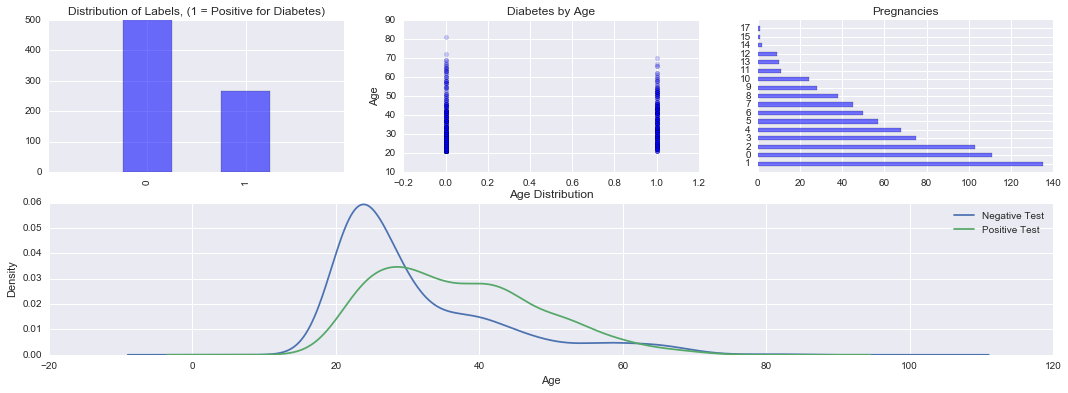

In [7]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

ax1 = plt.subplot2grid((2,3),(0,0))
df.Target.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax1.set_xlim(-1, 2)
plt.title("Distribution of Labels, (1 = Positive for Diabetes)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Target, df.Age, alpha=alpha_scatterplot)
plt.ylabel("Age")
plt.grid(b=True, which='major', axis='y')  
plt.title("Diabetes by Age")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pregnancies.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pregnancies.value_counts()))
plt.title("Pregnancies")

plt.subplot2grid((2,3),(1,0), colspan=3)
df.Age[df.Target == 0].plot(kind='kde')    
df.Age[df.Target == 1].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution")
plt.legend(('Negative Test', 'Positive Test'),loc='best') 

In [8]:
# Time to convert our pandas into numpy arrays.

features = df.drop(["Target"], axis=1).as_matrix()
print features.shape

labels = df.Target.values
print labels.shape

(768, 8)
(768,)


In [9]:
# Removing mean and dividing the standard deviation of features respectively.
scaler = StandardScaler()
features = scaler.fit_transform(features)

## Modelling time

In [10]:
# We don't have a test set so time to create one (75% train 25% test)
xTrain, xTest, yTrain, yTest = train_test_split(features, labels, test_size = 0.25)

# Stratified K Fold for unbalanced classes.
stratifiedKFold = StratifiedKFold(yTrain, n_folds=5, shuffle=True)

Accuracy Score using Logistic Regression: 0.776041666667

SVM classification report: 
              precision    recall  f1-score   support

Negative (0)       0.82      0.85      0.84       129
Positive (1)       0.67      0.62      0.64        63

 avg / total       0.77      0.78      0.77       192


SVM confusion matrix: 


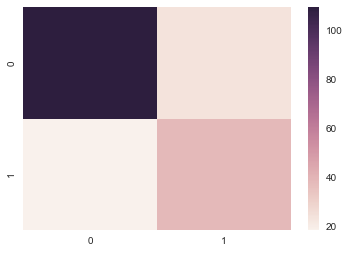

In [16]:
# Logistic Regression 

clf = LogisticRegressionCV(cv=stratifiedKFold)
clf.fit(xTrain, yTrain)

yPredictions = clf.predict(xTest)
print 'Accuracy Score using Logistic Regression: {}'.format(accuracy_score(yTest, yPredictions))

print "\nSVM classification report: "
print(classification_report(yTest, yPredictions, target_names=['Negative (0)', 'Positive (1)']))

print "\nSVM confusion matrix: "
sns.heatmap(confusion_matrix(yPredictions, yTest), an)

In [33]:
# Predict every test instance with label 0 (negative for diabetes)
'Accuracy using \'Every label = 0\' Classifier: {}'.format(accuracy_score(yTest, [0]*len(yTest)))

"Accuracy using 'Every label = 0' Classifier: 0.661458333333"

In [34]:
# K Nearest Neighbor Classifier using GridSearch

params = {'n_neighbors': [1,3,6]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn, params, cv=stratifiedKFold, refit=True)
clf.fit(xTrain, yTrain)

print 'best k = ', clf.best_params_.get('n_neighbors')

yPredictions = clf.predict(xTest)
'Accuracy using KNN Classifer: {}'.format(accuracy_score(yTest, yPredictions))

best k =  3


'Accuracy using KNN Classifer: 0.744791666667'

In [64]:
# Support vector machine(SVM)

clf = SVC(kernel='poly', class_weight='balanced',C=1)
clf.fit(xTrain, yTrain)

yPredictions = clf.predict(xTest)
'Accuracy using Support vector machine: {}'.format(accuracy_score(yTest, yPredictions))

'Accuracy using Support vector machine: 0.744791666667'

In [37]:
# Random Forest Classifier

clf = RandomForestClassifier(class_weight='balanced', n_estimators=1000)
clf.fit(xTrain, yTrain)

yPredictions = clf.predict(xTest)
'Accuracy using Random Forests: {}'.format(accuracy_score(yTest, yPredictions))

'Accuracy using Random Forests: 0.802083333333'

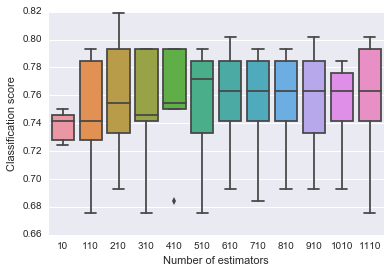

In [57]:
# Random Forest Classifier using cross validation

cvScores = []

estimators = range(10,1200,100)

for e in estimators:
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=e)
    cvScores.append(cross_val_score(clf, xTrain, yTrain, cv=5))

    
sns.boxplot(x=estimators,y=cvScores)
plt.xlabel('Number of estimators')
plt.ylabel('Classification score')

In [ ]:
# Support vector machine(SVM) using GridSearch

params = {'C': [0.01, 0.1, 1.0, 10.0, 100.0], 
          'gamma': [0.01, 0.1, 1.0, 10.0, 100.0]}


svc = SVC(kernel='poly', class_weight='balanced',random_state=27)

clf = GridSearchCV(svc, params, cv=stratifiedKFold, refit=True, scoring='accuracy', n_jobs=-2)
clf.fit(xTrain, yTrain)

print clf.best_params_

yPredictions = clf.predict(xTest)
'Accuracy using Support vector machine: {}'.format(accuracy_score(yTest, yPredictions))